In [47]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [53]:
df = pd.read_excel("etf_combined.xlsx", index_col='Date', parse_dates=True)

# Calculate log normal returns for each ticker

log_returns = np.log(df / df.shift(1)).dropna()

print(f"How many total tickers are there? {len(df.columns)}")


How many total tickers are there? 27


In [34]:
# Calculate Covariance Matrix
cov_matrix = log_returns.cov()*252 # We want to annualise the covariance matrix (our data is daily)

In [35]:
# Calculate the standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights # The @ operator is matrix multiplication
    return np.sqrt(variance)

# Calculate the expected return 3-yr
def expected_return(weights, log_returns):
    return np.sum(weights * log_returns.mean() * 252)

# Calculate the Sharpe ratio
risk_free_rate = 0.039
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [36]:
# As the scipy.optimize.minimize() function, we make our sharpe negative and minimise it

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


In [54]:
# Constraint conditions
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

bounds = tuple((0 , 0.50) for _ in range(len(df.columns)))

initial_weights = np.array([1/len(df.columns)] * len(df.columns))

In [55]:
# 'SLSQP' is Sequential Least Squares Programming, which is a type of optimisation algorithm that is used to find the minimum of a function.
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimized_results.x # .x is the optimal value of the many attributes that 'optimized_results' function returns

In [56]:
# Print
print("Optimal weights: ")
for ticker, weight in zip(df.columns, optimal_weights):
    print(f"{ticker}: {weight:.4%}")
print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal portfolio return: {optimal_portfolio_return:.4%}")
print(f"Optimal portfolio volatility: {optimal_portfolio_volatility:.4%}")
print(f"Optimal portfolio Sharpe ratio: {optimal_sharpe_ratio:.4f}")

Optimal weights: 
EMHG: 0.0000%
JGSA: 50.0000%
CRHG LN: 0.0000%
UBTP: 0.0000%
AGGG LN: 0.0000%
SGLN: 29.2025%
VICI: 0.0000%
DLR: 0.0000%
WMVG LN : 9.7260%
MVEU LN Equity: 1.2490%
SPMV LN: 0.0000%
EMMV LN : 0.0000%
BNAMEXI LN: 0.0000%
TECW LN: 9.4562%
GOAIGBIV: 0.0000%
ARTGEIG LN: 0.0000%
PARAQPG LX : 0.0000%
GAMSUZA ID : 0.0000%
ACWEIXG LN: 0.3663%
BGND4DS LX: 0.0000%
PIGEOZG LX: 0.0000%
CUKX LN : 0.0000%
PSRU LN Equity: 0.0000%
VUKE LN : 0.0000%
FFEDWGA LX: 0.0000%
IEFQ LN: 0.0000%
VGSESIE ID : 0.0000%

Optimal portfolio return: 11.0103%
Optimal portfolio volatility: 5.0698%
Optimal portfolio Sharpe ratio: 1.4025


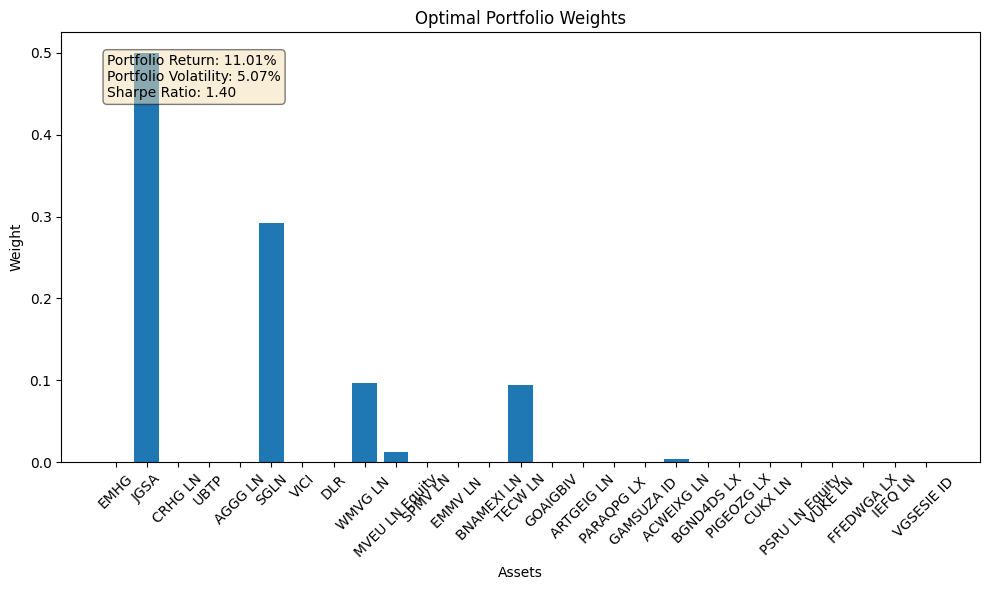

In [57]:
# Display the final results

plt.figure (figsize=(10, 6))
# Create a bar chart of the optimal weights
plt.bar(df.columns, optimal_weights)
plt.title('Optimal Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()

# Add a text box with portfolio metrics
textstr = '\n'.join((
    f'Portfolio Return: {optimal_portfolio_return:.2%}',
    f'Portfolio Volatility: {optimal_portfolio_volatility:.2%}',
    f'Sharpe Ratio: {optimal_sharpe_ratio:.2f}'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()

